# Library

In [1]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Others
import shutil
import random

# Dataset

In [2]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Vegetable Ripeness/Dataset/Chile Pepper/train",
    label_mode="categorical",
    class_names= ['damaged','dried','old','ripe','unripe'],
    color_mode="rgb",
    batch_size=10,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Vegetable Ripeness/Dataset/Chile Pepper/valid",
    label_mode="categorical",
    class_names= ['damaged','dried','old','ripe','unripe'],
    color_mode="rgb",
    batch_size=10,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 1611 files belonging to 5 classes.
==========================Validation Data====================
Found 601 files belonging to 5 classes.


In [3]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/256.)
test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 10 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Vegetable Ripeness/Dataset/Chile Pepper/train",
                                                    batch_size=10,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 10 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Vegetable Ripeness/Dataset/Chile Pepper/valid",
                                                         batch_size=10,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 1611 images belonging to 5 classes.
Found 601 images belonging to 5 classes.


# DenseNet 1

In [4]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="ChilePaper_DenseNet_model", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [5]:
# Define DIY Model
DenseNet121_model = tf.keras.models.Sequential([
    # DenseNet121 Layer
    DenseNet121(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(5, activation='softmax') 
  ])
DenseNet121_model.layers[0].trainable = False

# Compile Model
DenseNet121_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DenseNet121_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_max_pooling2d (Globa  (None, 1024)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 7,301,189
Trainable params: 263,685
Non-trainable params: 7,037,504
________________________________________

In [6]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DenseNet121_model_1 = DenseNet121_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
162/162 [==============================] - ETA: 0s - loss: 1.2551 - accuracy: 0.7027
Epoch 1: val_accuracy improved from -inf to 0.83527, saving model to ChilePaper_DenseNet_model


INFO:tensorflow:Assets written to: ChilePaper_DenseNet_model\assets


INFO:tensorflow:Assets written to: ChilePaper_DenseNet_model\assets


162/162 [==============================] - 50s 261ms/step - loss: 1.2551 - accuracy: 0.7027 - val_loss: 0.3938 - val_accuracy: 0.8353 - lr: 0.0010
Epoch 2/100
162/162 [==============================] - ETA: 0s - loss: 0.5068 - accuracy: 0.8330
Epoch 2: val_accuracy improved from 0.83527 to 0.87354, saving model to ChilePaper_DenseNet_model


INFO:tensorflow:Assets written to: ChilePaper_DenseNet_model\assets


INFO:tensorflow:Assets written to: ChilePaper_DenseNet_model\assets


162/162 [==============================] - 40s 247ms/step - loss: 0.5068 - accuracy: 0.8330 - val_loss: 0.3307 - val_accuracy: 0.8735 - lr: 0.0010
Epoch 3/100
162/162 [==============================] - ETA: 0s - loss: 0.4828 - accuracy: 0.8330
Epoch 3: val_accuracy did not improve from 0.87354
162/162 [==============================] - 7s 40ms/step - loss: 0.4828 - accuracy: 0.8330 - val_loss: 0.3417 - val_accuracy: 0.8569 - lr: 0.0010
Epoch 4/100
162/162 [==============================] - ETA: 0s - loss: 0.3092 - accuracy: 0.8901
Epoch 4: val_accuracy did not improve from 0.87354
162/162 [==============================] - 7s 40ms/step - loss: 0.3092 - accuracy: 0.8901 - val_loss: 0.4379 - val_accuracy: 0.8186 - lr: 0.0010
Epoch 5/100
161/162 [============================>.] - ETA: 0s - loss: 0.3086 - accuracy: 0.8851
Epoch 5: val_accuracy improved from 0.87354 to 0.89185, saving model to ChilePaper_DenseNet_model


INFO:tensorflow:Assets written to: ChilePaper_DenseNet_model\assets


INFO:tensorflow:Assets written to: ChilePaper_DenseNet_model\assets


162/162 [==============================] - 40s 248ms/step - loss: 0.3079 - accuracy: 0.8852 - val_loss: 0.2841 - val_accuracy: 0.8918 - lr: 0.0010
Epoch 6/100
161/162 [============================>.] - ETA: 0s - loss: 0.2691 - accuracy: 0.8969
Epoch 6: val_accuracy improved from 0.89185 to 0.89517, saving model to ChilePaper_DenseNet_model


INFO:tensorflow:Assets written to: ChilePaper_DenseNet_model\assets


INFO:tensorflow:Assets written to: ChilePaper_DenseNet_model\assets


162/162 [==============================] - 41s 255ms/step - loss: 0.2712 - accuracy: 0.8957 - val_loss: 0.3561 - val_accuracy: 0.8952 - lr: 0.0010
Epoch 7/100
161/162 [============================>.] - ETA: 0s - loss: 0.2402 - accuracy: 0.9107
Epoch 7: val_accuracy improved from 0.89517 to 0.91681, saving model to ChilePaper_DenseNet_model


INFO:tensorflow:Assets written to: ChilePaper_DenseNet_model\assets


INFO:tensorflow:Assets written to: ChilePaper_DenseNet_model\assets


162/162 [==============================] - 43s 264ms/step - loss: 0.2388 - accuracy: 0.9112 - val_loss: 0.2361 - val_accuracy: 0.9168 - lr: 0.0010
Epoch 8/100
162/162 [==============================] - ETA: 0s - loss: 0.1958 - accuracy: 0.9317
Epoch 8: val_accuracy did not improve from 0.91681
162/162 [==============================] - 7s 41ms/step - loss: 0.1958 - accuracy: 0.9317 - val_loss: 0.2918 - val_accuracy: 0.8935 - lr: 0.0010
Epoch 9/100
161/162 [============================>.] - ETA: 0s - loss: 0.2186 - accuracy: 0.9225
Epoch 9: val_accuracy did not improve from 0.91681
162/162 [==============================] - 7s 42ms/step - loss: 0.2231 - accuracy: 0.9218 - val_loss: 0.3433 - val_accuracy: 0.9101 - lr: 0.0010
Epoch 10/100
161/162 [============================>.] - ETA: 0s - loss: 0.2042 - accuracy: 0.9257
Epoch 10: val_accuracy did not improve from 0.91681
162/162 [==============================] - 7s 42ms/step - loss: 0.2070 - accuracy: 0.9249 - val_loss: 0.2890 - val_ac

INFO:tensorflow:Assets written to: ChilePaper_DenseNet_model\assets


INFO:tensorflow:Assets written to: ChilePaper_DenseNet_model\assets


162/162 [==============================] - 44s 275ms/step - loss: 0.1773 - accuracy: 0.9354 - val_loss: 0.2347 - val_accuracy: 0.9235 - lr: 0.0010
Epoch 13/100
161/162 [============================>.] - ETA: 0s - loss: 0.1679 - accuracy: 0.9319
Epoch 13: val_accuracy did not improve from 0.92346
162/162 [==============================] - 7s 42ms/step - loss: 0.1700 - accuracy: 0.9311 - val_loss: 0.2987 - val_accuracy: 0.8869 - lr: 0.0010
Epoch 14/100
162/162 [==============================] - ETA: 0s - loss: 0.1473 - accuracy: 0.9410
Epoch 14: val_accuracy did not improve from 0.92346
162/162 [==============================] - 7s 41ms/step - loss: 0.1473 - accuracy: 0.9410 - val_loss: 0.2242 - val_accuracy: 0.9235 - lr: 0.0010
Epoch 15/100
162/162 [==============================] - ETA: 0s - loss: 0.1589 - accuracy: 0.9398
Epoch 15: val_accuracy did not improve from 0.92346
162/162 [==============================] - 7s 41ms/step - loss: 0.1589 - accuracy: 0.9398 - val_loss: 0.2906 - va

INFO:tensorflow:Assets written to: ChilePaper_DenseNet_model\assets


INFO:tensorflow:Assets written to: ChilePaper_DenseNet_model\assets


162/162 [==============================] - 41s 256ms/step - loss: 0.1034 - accuracy: 0.9652 - val_loss: 0.2054 - val_accuracy: 0.9384 - lr: 1.0000e-04
Epoch 21/100
162/162 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 0.9727
Epoch 21: val_accuracy did not improve from 0.93844
162/162 [==============================] - 7s 41ms/step - loss: 0.0765 - accuracy: 0.9727 - val_loss: 0.1973 - val_accuracy: 0.9368 - lr: 1.0000e-04
Epoch 22/100
162/162 [==============================] - ETA: 0s - loss: 0.0776 - accuracy: 0.9721
Epoch 22: val_accuracy did not improve from 0.93844
162/162 [==============================] - 7s 41ms/step - loss: 0.0776 - accuracy: 0.9721 - val_loss: 0.1966 - val_accuracy: 0.9351 - lr: 1.0000e-04
Epoch 23/100
161/162 [============================>.] - ETA: 0s - loss: 0.0769 - accuracy: 0.9694
Epoch 23: val_accuracy did not improve from 0.93844
162/162 [==============================] - 7s 41ms/step - loss: 0.0770 - accuracy: 0.9696 - val_loss:

INFO:tensorflow:Assets written to: ChilePaper_DenseNet_model\assets


INFO:tensorflow:Assets written to: ChilePaper_DenseNet_model\assets


162/162 [==============================] - 41s 256ms/step - loss: 0.0510 - accuracy: 0.9839 - val_loss: 0.1851 - val_accuracy: 0.9484 - lr: 1.0000e-04
Epoch 26/100
162/162 [==============================] - ETA: 0s - loss: 0.0752 - accuracy: 0.9727
Epoch 26: val_accuracy did not improve from 0.94842
162/162 [==============================] - 7s 41ms/step - loss: 0.0752 - accuracy: 0.9727 - val_loss: 0.1915 - val_accuracy: 0.9384 - lr: 1.0000e-04
Epoch 27/100
162/162 [==============================] - ETA: 0s - loss: 0.0726 - accuracy: 0.9702
Epoch 27: val_accuracy did not improve from 0.94842
162/162 [==============================] - 7s 42ms/step - loss: 0.0726 - accuracy: 0.9702 - val_loss: 0.1854 - val_accuracy: 0.9451 - lr: 1.0000e-04
Epoch 28/100
161/162 [============================>.] - ETA: 0s - loss: 0.0714 - accuracy: 0.9725
Epoch 28: val_accuracy did not improve from 0.94842
162/162 [==============================] - 7s 42ms/step - loss: 0.0710 - accuracy: 0.9727 - val_loss:

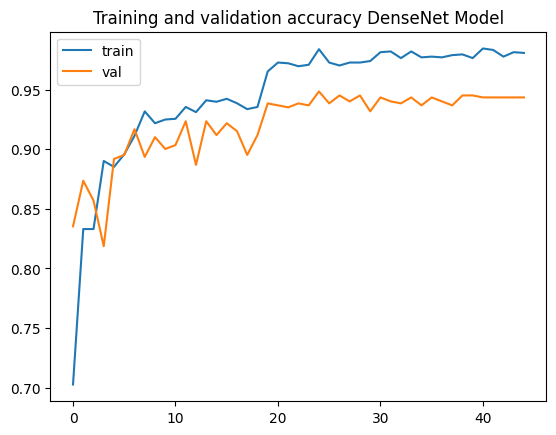

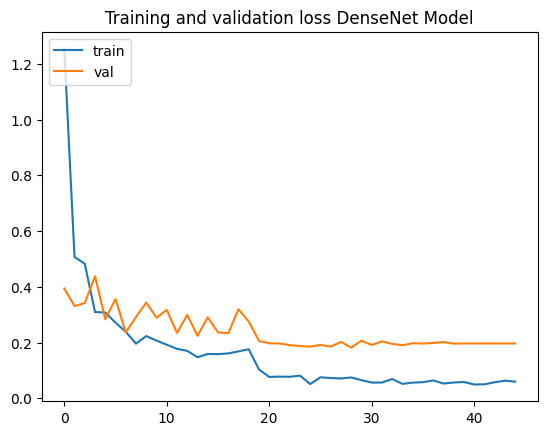

In [7]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DenseNet121_model_1.history['accuracy' ]
val_acc  = history_DenseNet121_model_1.history['val_accuracy' ]
loss     = history_DenseNet121_model_1.history['loss' ]
val_loss = history_DenseNet121_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DenseNet Model')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DenseNet Model')
plt.legend(['train', 'val'], loc='upper left')

# DenseNet 2

In [8]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="ChilePaper_DenseNet2_model", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [9]:
# Define DIY Model
DenseNet121_model2 = tf.keras.models.Sequential([
    # DenseNet121 Layer
    DenseNet121(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(5, activation='softmax') 
  ])
DenseNet121_model2.layers[0].trainable = False

# Compile Model
DenseNet121_model2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DenseNet121_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 7,301,189
Trainable params: 263,685
Non-trainable params: 7,037,504
______________________________________

In [10]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DenseNet121_model_2 = DenseNet121_model2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
161/162 [============================>.] - ETA: 0s - loss: 0.6797 - accuracy: 0.7402
Epoch 1: val_accuracy improved from -inf to 0.87521, saving model to ChilePaper_DenseNet2_model


INFO:tensorflow:Assets written to: ChilePaper_DenseNet2_model\assets


INFO:tensorflow:Assets written to: ChilePaper_DenseNet2_model\assets


162/162 [==============================] - 50s 279ms/step - loss: 0.6766 - accuracy: 0.7418 - val_loss: 0.3271 - val_accuracy: 0.8752 - lr: 0.0010
Epoch 2/100
162/162 [==============================] - ETA: 0s - loss: 0.3639 - accuracy: 0.8641
Epoch 2: val_accuracy improved from 0.87521 to 0.89684, saving model to ChilePaper_DenseNet2_model


INFO:tensorflow:Assets written to: ChilePaper_DenseNet2_model\assets


INFO:tensorflow:Assets written to: ChilePaper_DenseNet2_model\assets


162/162 [==============================] - 43s 262ms/step - loss: 0.3639 - accuracy: 0.8641 - val_loss: 0.2907 - val_accuracy: 0.8968 - lr: 0.0010
Epoch 3/100
161/162 [============================>.] - ETA: 0s - loss: 0.2397 - accuracy: 0.9069
Epoch 3: val_accuracy did not improve from 0.89684
162/162 [==============================] - 7s 42ms/step - loss: 0.2388 - accuracy: 0.9075 - val_loss: 0.2814 - val_accuracy: 0.8902 - lr: 0.0010
Epoch 4/100
161/162 [============================>.] - ETA: 0s - loss: 0.2361 - accuracy: 0.9068
Epoch 4: val_accuracy improved from 0.89684 to 0.91681, saving model to ChilePaper_DenseNet2_model


INFO:tensorflow:Assets written to: ChilePaper_DenseNet2_model\assets


INFO:tensorflow:Assets written to: ChilePaper_DenseNet2_model\assets


162/162 [==============================] - 44s 270ms/step - loss: 0.2366 - accuracy: 0.9063 - val_loss: 0.2211 - val_accuracy: 0.9168 - lr: 0.0010
Epoch 5/100
161/162 [============================>.] - ETA: 0s - loss: 0.2363 - accuracy: 0.9032
Epoch 5: val_accuracy did not improve from 0.91681
162/162 [==============================] - 7s 41ms/step - loss: 0.2376 - accuracy: 0.9025 - val_loss: 0.2308 - val_accuracy: 0.9035 - lr: 0.0010
Epoch 6/100
161/162 [============================>.] - ETA: 0s - loss: 0.2093 - accuracy: 0.9188
Epoch 6: val_accuracy improved from 0.91681 to 0.92512, saving model to ChilePaper_DenseNet2_model


INFO:tensorflow:Assets written to: ChilePaper_DenseNet2_model\assets


INFO:tensorflow:Assets written to: ChilePaper_DenseNet2_model\assets


162/162 [==============================] - 42s 260ms/step - loss: 0.2125 - accuracy: 0.9181 - val_loss: 0.2588 - val_accuracy: 0.9251 - lr: 0.0010
Epoch 7/100
161/162 [============================>.] - ETA: 0s - loss: 0.2038 - accuracy: 0.9213
Epoch 7: val_accuracy did not improve from 0.92512
162/162 [==============================] - 7s 42ms/step - loss: 0.2025 - accuracy: 0.9218 - val_loss: 0.2078 - val_accuracy: 0.9185 - lr: 0.0010
Epoch 8/100
161/162 [============================>.] - ETA: 0s - loss: 0.1671 - accuracy: 0.9388
Epoch 8: val_accuracy improved from 0.92512 to 0.92679, saving model to ChilePaper_DenseNet2_model


INFO:tensorflow:Assets written to: ChilePaper_DenseNet2_model\assets


INFO:tensorflow:Assets written to: ChilePaper_DenseNet2_model\assets


162/162 [==============================] - 43s 264ms/step - loss: 0.1663 - accuracy: 0.9392 - val_loss: 0.2081 - val_accuracy: 0.9268 - lr: 0.0010
Epoch 9/100
161/162 [============================>.] - ETA: 0s - loss: 0.1656 - accuracy: 0.9400
Epoch 9: val_accuracy improved from 0.92679 to 0.93012, saving model to ChilePaper_DenseNet2_model


INFO:tensorflow:Assets written to: ChilePaper_DenseNet2_model\assets


INFO:tensorflow:Assets written to: ChilePaper_DenseNet2_model\assets


162/162 [==============================] - 42s 262ms/step - loss: 0.1647 - accuracy: 0.9404 - val_loss: 0.1855 - val_accuracy: 0.9301 - lr: 0.0010
Epoch 10/100
162/162 [==============================] - ETA: 0s - loss: 0.1457 - accuracy: 0.9410
Epoch 10: val_accuracy improved from 0.93012 to 0.93178, saving model to ChilePaper_DenseNet2_model


INFO:tensorflow:Assets written to: ChilePaper_DenseNet2_model\assets


INFO:tensorflow:Assets written to: ChilePaper_DenseNet2_model\assets


162/162 [==============================] - 43s 266ms/step - loss: 0.1457 - accuracy: 0.9410 - val_loss: 0.1880 - val_accuracy: 0.9318 - lr: 0.0010
Epoch 11/100
161/162 [============================>.] - ETA: 0s - loss: 0.1645 - accuracy: 0.9363
Epoch 11: val_accuracy did not improve from 0.93178
162/162 [==============================] - 7s 43ms/step - loss: 0.1637 - accuracy: 0.9367 - val_loss: 0.2393 - val_accuracy: 0.9135 - lr: 0.0010
Epoch 12/100
161/162 [============================>.] - ETA: 0s - loss: 0.1492 - accuracy: 0.9419
Epoch 12: val_accuracy did not improve from 0.93178
162/162 [==============================] - 7s 43ms/step - loss: 0.1500 - accuracy: 0.9417 - val_loss: 0.4971 - val_accuracy: 0.8220 - lr: 0.0010
Epoch 13/100
162/162 [==============================] - ETA: 0s - loss: 0.1192 - accuracy: 0.9528
Epoch 13: val_accuracy did not improve from 0.93178
162/162 [==============================] - 7s 42ms/step - loss: 0.1192 - accuracy: 0.9528 - val_loss: 0.3540 - va

INFO:tensorflow:Assets written to: ChilePaper_DenseNet2_model\assets


INFO:tensorflow:Assets written to: ChilePaper_DenseNet2_model\assets


162/162 [==============================] - 43s 266ms/step - loss: 0.0839 - accuracy: 0.9690 - val_loss: 0.1721 - val_accuracy: 0.9384 - lr: 1.0000e-04
Epoch 16/100
161/162 [============================>.] - ETA: 0s - loss: 0.0875 - accuracy: 0.9681
Epoch 16: val_accuracy did not improve from 0.93844
162/162 [==============================] - 7s 43ms/step - loss: 0.0871 - accuracy: 0.9683 - val_loss: 0.1781 - val_accuracy: 0.9268 - lr: 1.0000e-04
Epoch 17/100
161/162 [============================>.] - ETA: 0s - loss: 0.0784 - accuracy: 0.9719
Epoch 17: val_accuracy did not improve from 0.93844
162/162 [==============================] - 7s 42ms/step - loss: 0.0779 - accuracy: 0.9721 - val_loss: 0.1762 - val_accuracy: 0.9368 - lr: 1.0000e-04
Epoch 18/100
161/162 [============================>.] - ETA: 0s - loss: 0.0752 - accuracy: 0.9738
Epoch 18: val_accuracy did not improve from 0.93844
162/162 [==============================] - 7s 43ms/step - loss: 0.0752 - accuracy: 0.9739 - val_loss:

INFO:tensorflow:Assets written to: ChilePaper_DenseNet2_model\assets


INFO:tensorflow:Assets written to: ChilePaper_DenseNet2_model\assets


162/162 [==============================] - 43s 266ms/step - loss: 0.0707 - accuracy: 0.9714 - val_loss: 0.1638 - val_accuracy: 0.9451 - lr: 1.0000e-04
Epoch 20/100
162/162 [==============================] - ETA: 0s - loss: 0.0595 - accuracy: 0.9795
Epoch 20: val_accuracy did not improve from 0.94509
162/162 [==============================] - 7s 43ms/step - loss: 0.0595 - accuracy: 0.9795 - val_loss: 0.1703 - val_accuracy: 0.9351 - lr: 1.0000e-04
Epoch 21/100
162/162 [==============================] - ETA: 0s - loss: 0.0691 - accuracy: 0.9721
Epoch 21: val_accuracy did not improve from 0.94509
162/162 [==============================] - 7s 43ms/step - loss: 0.0691 - accuracy: 0.9721 - val_loss: 0.1585 - val_accuracy: 0.9434 - lr: 1.0000e-04
Epoch 22/100
161/162 [============================>.] - ETA: 0s - loss: 0.0798 - accuracy: 0.9675
Epoch 22: val_accuracy did not improve from 0.94509
162/162 [==============================] - 7s 43ms/step - loss: 0.0802 - accuracy: 0.9671 - val_loss:

INFO:tensorflow:Assets written to: ChilePaper_DenseNet2_model\assets


INFO:tensorflow:Assets written to: ChilePaper_DenseNet2_model\assets



Epoch 26: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
162/162 [==============================] - 43s 264ms/step - loss: 0.0630 - accuracy: 0.9777 - val_loss: 0.1614 - val_accuracy: 0.9468 - lr: 1.0000e-04
Epoch 27/100
161/162 [============================>.] - ETA: 0s - loss: 0.0519 - accuracy: 0.9831
Epoch 27: val_accuracy did not improve from 0.94676
162/162 [==============================] - 7s 42ms/step - loss: 0.0516 - accuracy: 0.9832 - val_loss: 0.1611 - val_accuracy: 0.9468 - lr: 1.0000e-05
Epoch 28/100
161/162 [============================>.] - ETA: 0s - loss: 0.0529 - accuracy: 0.9794
Epoch 28: val_accuracy did not improve from 0.94676
162/162 [==============================] - 7s 42ms/step - loss: 0.0534 - accuracy: 0.9789 - val_loss: 0.1620 - val_accuracy: 0.9451 - lr: 1.0000e-05
Epoch 29/100
162/162 [==============================] - ETA: 0s - loss: 0.0507 - accuracy: 0.9845
Epoch 29: val_accuracy did not improve from 0.94676
162/162 [=============

INFO:tensorflow:Assets written to: ChilePaper_DenseNet2_model\assets


INFO:tensorflow:Assets written to: ChilePaper_DenseNet2_model\assets



Epoch 31: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
162/162 [==============================] - 43s 266ms/step - loss: 0.0523 - accuracy: 0.9851 - val_loss: 0.1618 - val_accuracy: 0.9484 - lr: 1.0000e-05
Epoch 32/100
161/162 [============================>.] - ETA: 0s - loss: 0.0590 - accuracy: 0.9794
Epoch 32: val_accuracy did not improve from 0.94842
162/162 [==============================] - 7s 42ms/step - loss: 0.0589 - accuracy: 0.9795 - val_loss: 0.1617 - val_accuracy: 0.9484 - lr: 1.0000e-06
Epoch 33/100
161/162 [============================>.] - ETA: 0s - loss: 0.0563 - accuracy: 0.9788
Epoch 33: val_accuracy did not improve from 0.94842
162/162 [==============================] - 7s 42ms/step - loss: 0.0564 - accuracy: 0.9789 - val_loss: 0.1623 - val_accuracy: 0.9484 - lr: 1.0000e-06
Epoch 34/100
161/162 [============================>.] - ETA: 0s - loss: 0.0577 - accuracy: 0.9825
Epoch 34: val_accuracy did not improve from 0.94842
162/162 [=============

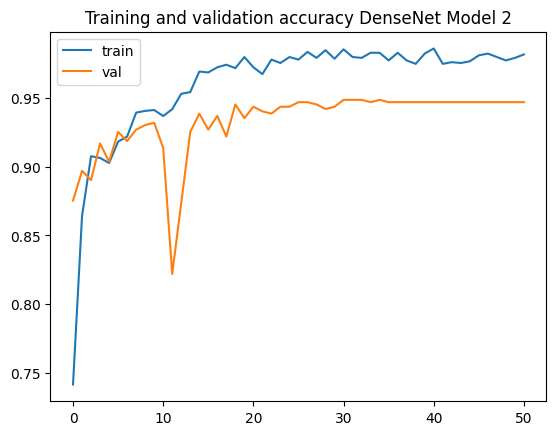

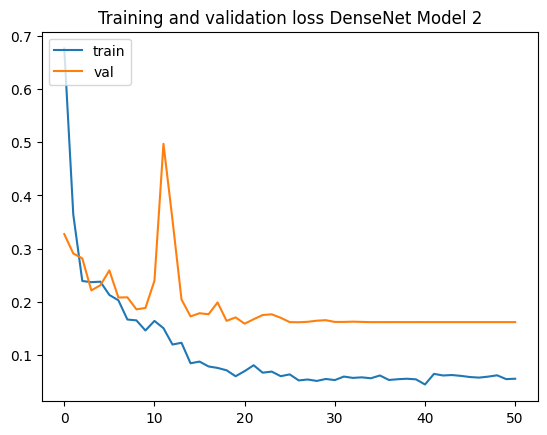

In [11]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DenseNet121_model_2.history['accuracy' ]
val_acc  = history_DenseNet121_model_2.history['val_accuracy' ]
loss     = history_DenseNet121_model_2.history['loss' ]
val_loss = history_DenseNet121_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DenseNet Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DenseNet Model 2')
plt.legend(['train', 'val'], loc='upper left')

# MobileNet V2

In [12]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="ChilePaper_MobileNetV2_model", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [13]:
# Define DIY Model
MobileNetV2_model = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(5, activation='softmax') 
  ])
MobileNetV2_model.layers[0].trainable = False

# Compile Model
MobileNetV2_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d_1 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 dense_5 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 2,587,205
Trainable params: 329,221
Non-

In [14]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_1 = MobileNetV2_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
161/162 [============================>.] - ETA: 0s - loss: 1.9980 - accuracy: 0.6334
Epoch 1: val_accuracy improved from -inf to 0.75374, saving model to ChilePaper_MobileNetV2_model


INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model\assets


INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model\assets


162/162 [==============================] - 22s 119ms/step - loss: 1.9896 - accuracy: 0.6344 - val_loss: 0.5858 - val_accuracy: 0.7537 - lr: 0.0010
Epoch 2/100
161/162 [============================>.] - ETA: 0s - loss: 0.5128 - accuracy: 0.8126
Epoch 2: val_accuracy improved from 0.75374 to 0.76040, saving model to ChilePaper_MobileNetV2_model


INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model\assets


INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model\assets


162/162 [==============================] - 18s 108ms/step - loss: 0.5113 - accuracy: 0.8125 - val_loss: 0.5553 - val_accuracy: 0.7604 - lr: 0.0010
Epoch 3/100
160/162 [============================>.] - ETA: 0s - loss: 0.3826 - accuracy: 0.8523
Epoch 3: val_accuracy improved from 0.76040 to 0.85358, saving model to ChilePaper_MobileNetV2_model


INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model\assets


INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model\assets


162/162 [==============================] - 18s 112ms/step - loss: 0.3893 - accuracy: 0.8504 - val_loss: 0.5101 - val_accuracy: 0.8536 - lr: 0.0010
Epoch 4/100
161/162 [============================>.] - ETA: 0s - loss: 0.3494 - accuracy: 0.8695
Epoch 4: val_accuracy improved from 0.85358 to 0.88353, saving model to ChilePaper_MobileNetV2_model


INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model\assets


INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model\assets


162/162 [==============================] - 19s 116ms/step - loss: 0.3476 - accuracy: 0.8703 - val_loss: 0.2994 - val_accuracy: 0.8835 - lr: 0.0010
Epoch 5/100
161/162 [============================>.] - ETA: 0s - loss: 0.2629 - accuracy: 0.8926
Epoch 5: val_accuracy did not improve from 0.88353
162/162 [==============================] - 4s 26ms/step - loss: 0.2646 - accuracy: 0.8920 - val_loss: 0.5018 - val_accuracy: 0.8103 - lr: 0.0010
Epoch 6/100
161/162 [============================>.] - ETA: 0s - loss: 0.2274 - accuracy: 0.9138
Epoch 6: val_accuracy improved from 0.88353 to 0.89517, saving model to ChilePaper_MobileNetV2_model


INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model\assets


INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model\assets


162/162 [==============================] - 18s 113ms/step - loss: 0.2264 - accuracy: 0.9143 - val_loss: 0.3412 - val_accuracy: 0.8952 - lr: 0.0010
Epoch 7/100
160/162 [============================>.] - ETA: 0s - loss: 0.2083 - accuracy: 0.9239
Epoch 7: val_accuracy did not improve from 0.89517
162/162 [==============================] - 4s 24ms/step - loss: 0.2139 - accuracy: 0.9218 - val_loss: 0.4595 - val_accuracy: 0.8369 - lr: 0.0010
Epoch 8/100
160/162 [============================>.] - ETA: 0s - loss: 0.1920 - accuracy: 0.9283
Epoch 8: val_accuracy did not improve from 0.89517
162/162 [==============================] - 4s 24ms/step - loss: 0.1954 - accuracy: 0.9268 - val_loss: 0.6300 - val_accuracy: 0.7720 - lr: 0.0010
Epoch 9/100
160/162 [============================>.] - ETA: 0s - loss: 0.2070 - accuracy: 0.9227
Epoch 9: val_accuracy did not improve from 0.89517

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
162/162 [==============================] 

INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model\assets


INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model\assets


162/162 [==============================] - 18s 110ms/step - loss: 0.1006 - accuracy: 0.9665 - val_loss: 0.2719 - val_accuracy: 0.9185 - lr: 1.0000e-04
Epoch 11/100
161/162 [============================>.] - ETA: 0s - loss: 0.0847 - accuracy: 0.9713
Epoch 11: val_accuracy did not improve from 0.91847
162/162 [==============================] - 4s 24ms/step - loss: 0.0844 - accuracy: 0.9714 - val_loss: 0.2777 - val_accuracy: 0.9185 - lr: 1.0000e-04
Epoch 12/100
159/162 [============================>.] - ETA: 0s - loss: 0.0732 - accuracy: 0.9760
Epoch 12: val_accuracy did not improve from 0.91847
162/162 [==============================] - 4s 24ms/step - loss: 0.0731 - accuracy: 0.9758 - val_loss: 0.2996 - val_accuracy: 0.8952 - lr: 1.0000e-04
Epoch 13/100
161/162 [============================>.] - ETA: 0s - loss: 0.0775 - accuracy: 0.9775
Epoch 13: val_accuracy improved from 0.91847 to 0.92180, saving model to ChilePaper_MobileNetV2_model


INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model\assets


INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model\assets


162/162 [==============================] - 18s 109ms/step - loss: 0.0782 - accuracy: 0.9770 - val_loss: 0.2685 - val_accuracy: 0.9218 - lr: 1.0000e-04
Epoch 14/100
162/162 [==============================] - ETA: 0s - loss: 0.0737 - accuracy: 0.9721
Epoch 14: val_accuracy did not improve from 0.92180
162/162 [==============================] - 4s 25ms/step - loss: 0.0737 - accuracy: 0.9721 - val_loss: 0.2799 - val_accuracy: 0.9168 - lr: 1.0000e-04
Epoch 15/100
162/162 [==============================] - ETA: 0s - loss: 0.0682 - accuracy: 0.9764
Epoch 15: val_accuracy did not improve from 0.92180
162/162 [==============================] - 4s 25ms/step - loss: 0.0682 - accuracy: 0.9764 - val_loss: 0.3045 - val_accuracy: 0.9002 - lr: 1.0000e-04
Epoch 16/100
160/162 [============================>.] - ETA: 0s - loss: 0.0654 - accuracy: 0.9786
Epoch 16: val_accuracy did not improve from 0.92180
162/162 [==============================] - 4s 24ms/step - loss: 0.0655 - accuracy: 0.9783 - val_loss:

INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model\assets


INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model\assets


162/162 [==============================] - 17s 108ms/step - loss: 0.0607 - accuracy: 0.9814 - val_loss: 0.2578 - val_accuracy: 0.9235 - lr: 1.0000e-04
Epoch 21/100
161/162 [============================>.] - ETA: 0s - loss: 0.0574 - accuracy: 0.9819
Epoch 21: val_accuracy did not improve from 0.92346
162/162 [==============================] - 4s 25ms/step - loss: 0.0572 - accuracy: 0.9820 - val_loss: 0.2950 - val_accuracy: 0.9052 - lr: 1.0000e-04
Epoch 22/100
160/162 [============================>.] - ETA: 0s - loss: 0.0659 - accuracy: 0.9799
Epoch 22: val_accuracy improved from 0.92346 to 0.92512, saving model to ChilePaper_MobileNetV2_model


INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model\assets


INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model\assets


162/162 [==============================] - 18s 110ms/step - loss: 0.0652 - accuracy: 0.9801 - val_loss: 0.2586 - val_accuracy: 0.9251 - lr: 1.0000e-04
Epoch 23/100
160/162 [============================>.] - ETA: 0s - loss: 0.0660 - accuracy: 0.9755
Epoch 23: val_accuracy did not improve from 0.92512
162/162 [==============================] - 4s 24ms/step - loss: 0.0653 - accuracy: 0.9758 - val_loss: 0.3154 - val_accuracy: 0.8885 - lr: 1.0000e-04
Epoch 24/100
160/162 [============================>.] - ETA: 0s - loss: 0.0539 - accuracy: 0.9830
Epoch 24: val_accuracy did not improve from 0.92512
162/162 [==============================] - 4s 24ms/step - loss: 0.0535 - accuracy: 0.9832 - val_loss: 0.2817 - val_accuracy: 0.9101 - lr: 1.0000e-04
Epoch 25/100
159/162 [============================>.] - ETA: 0s - loss: 0.0554 - accuracy: 0.9823
Epoch 25: val_accuracy did not improve from 0.92512

Epoch 25: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
162/162 [=============

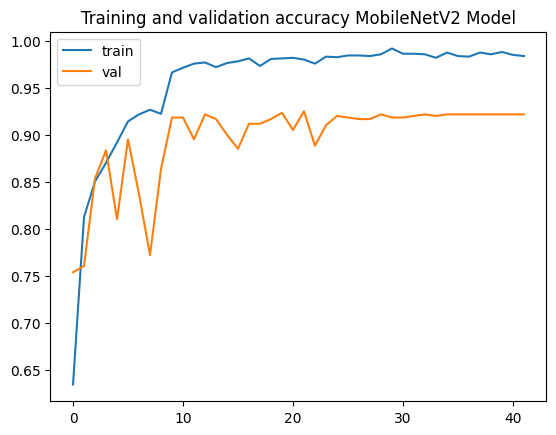

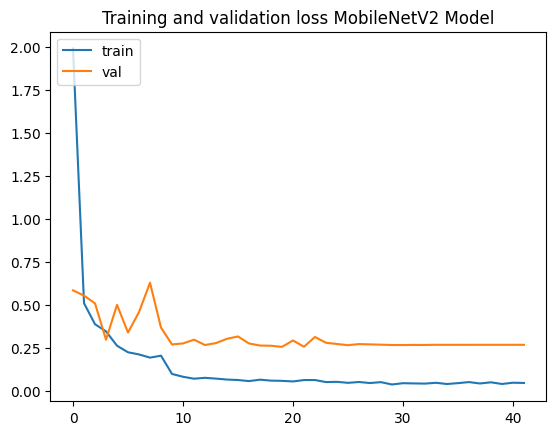

In [15]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_1.history['accuracy' ]
val_acc  = history_MobileNetV2_model_1.history['val_accuracy' ]
loss     = history_MobileNetV2_model_1.history['loss' ]
val_loss = history_MobileNetV2_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model')
plt.legend(['train', 'val'], loc='upper left')

# MobileNetV2 2

In [16]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="ChilePaper_MobileNetV2_model2", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [17]:
# Define DIY Model
MobileNetV2_model2 = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(5, activation='softmax') 
  ])
MobileNetV2_model2.layers[0].trainable = False

# Compile Model
MobileNetV2_model2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
 dense_7 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 2,587,205
Trainable params: 329,221
Non-

In [18]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_2 = MobileNetV2_model2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
161/162 [============================>.] - ETA: 0s - loss: 0.6367 - accuracy: 0.7502
Epoch 1: val_accuracy improved from -inf to 0.84193, saving model to ChilePaper_MobileNetV2_model2


INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model2\assets


INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model2\assets


162/162 [==============================] - 20s 115ms/step - loss: 0.6333 - accuracy: 0.7517 - val_loss: 0.4561 - val_accuracy: 0.8419 - lr: 0.0010
Epoch 2/100
160/162 [============================>.] - ETA: 0s - loss: 0.3359 - accuracy: 0.8730
Epoch 2: val_accuracy improved from 0.84193 to 0.88186, saving model to ChilePaper_MobileNetV2_model2


INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model2\assets


INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model2\assets


162/162 [==============================] - 18s 109ms/step - loss: 0.3328 - accuracy: 0.8740 - val_loss: 0.3357 - val_accuracy: 0.8819 - lr: 0.0010
Epoch 3/100
162/162 [==============================] - ETA: 0s - loss: 0.2335 - accuracy: 0.9112
Epoch 3: val_accuracy did not improve from 0.88186
162/162 [==============================] - 4s 24ms/step - loss: 0.2335 - accuracy: 0.9112 - val_loss: 0.3817 - val_accuracy: 0.8802 - lr: 0.0010
Epoch 4/100
160/162 [============================>.] - ETA: 0s - loss: 0.1921 - accuracy: 0.9296
Epoch 4: val_accuracy did not improve from 0.88186
162/162 [==============================] - 5s 28ms/step - loss: 0.1954 - accuracy: 0.9280 - val_loss: 0.4518 - val_accuracy: 0.8569 - lr: 0.0010
Epoch 5/100
162/162 [==============================] - ETA: 0s - loss: 0.1550 - accuracy: 0.9423
Epoch 5: val_accuracy did not improve from 0.88186
162/162 [==============================] - 4s 26ms/step - loss: 0.1550 - accuracy: 0.9423 - val_loss: 0.3829 - val_accu

INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model2\assets


INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model2\assets


162/162 [==============================] - 19s 116ms/step - loss: 0.1397 - accuracy: 0.9435 - val_loss: 0.2841 - val_accuracy: 0.9251 - lr: 0.0010
Epoch 7/100
162/162 [==============================] - ETA: 0s - loss: 0.1520 - accuracy: 0.9472
Epoch 7: val_accuracy did not improve from 0.92512
162/162 [==============================] - 5s 27ms/step - loss: 0.1520 - accuracy: 0.9472 - val_loss: 0.3038 - val_accuracy: 0.9018 - lr: 0.0010
Epoch 8/100
160/162 [============================>.] - ETA: 0s - loss: 0.0971 - accuracy: 0.9617
Epoch 8: val_accuracy did not improve from 0.92512
162/162 [==============================] - 5s 29ms/step - loss: 0.0963 - accuracy: 0.9621 - val_loss: 0.3408 - val_accuracy: 0.9168 - lr: 0.0010
Epoch 9/100
160/162 [============================>.] - ETA: 0s - loss: 0.0819 - accuracy: 0.9686
Epoch 9: val_accuracy did not improve from 0.92512
162/162 [==============================] - 4s 26ms/step - loss: 0.0821 - accuracy: 0.9683 - val_loss: 0.2691 - val_accu

INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model2\assets


INFO:tensorflow:Assets written to: ChilePaper_MobileNetV2_model2\assets


162/162 [==============================] - 19s 115ms/step - loss: 0.0361 - accuracy: 0.9894 - val_loss: 0.2706 - val_accuracy: 0.9351 - lr: 1.0000e-04
Epoch 16/100
160/162 [============================>.] - ETA: 0s - loss: 0.0230 - accuracy: 0.9937
Epoch 16: val_accuracy did not improve from 0.93511
162/162 [==============================] - 4s 24ms/step - loss: 0.0228 - accuracy: 0.9938 - val_loss: 0.2671 - val_accuracy: 0.9334 - lr: 1.0000e-04
Epoch 17/100
160/162 [============================>.] - ETA: 0s - loss: 0.0250 - accuracy: 0.9943
Epoch 17: val_accuracy did not improve from 0.93511
162/162 [==============================] - 4s 25ms/step - loss: 0.0251 - accuracy: 0.9944 - val_loss: 0.2953 - val_accuracy: 0.9318 - lr: 1.0000e-04
Epoch 18/100
161/162 [============================>.] - ETA: 0s - loss: 0.0182 - accuracy: 0.9969
Epoch 18: val_accuracy did not improve from 0.93511
162/162 [==============================] - 4s 24ms/step - loss: 0.0181 - accuracy: 0.9969 - val_loss:

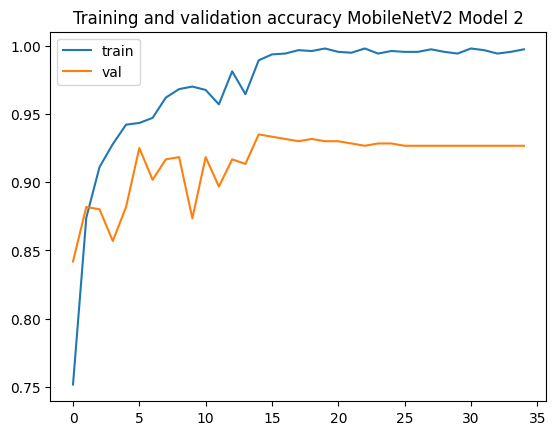

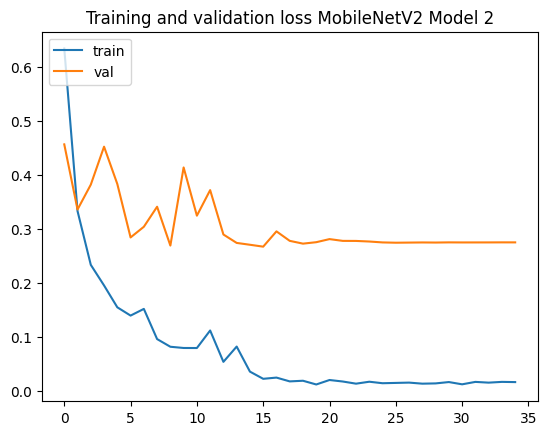

In [19]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_2.history['accuracy' ]
val_acc  = history_MobileNetV2_model_2.history['val_accuracy' ]
loss     = history_MobileNetV2_model_2.history['loss' ]
val_loss = history_MobileNetV2_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')

# Xception

In [20]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="ChilePaper_Xception_model", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [21]:
# Define Model
Xception_model = tf.keras.models.Sequential([
    # Xception Layer
    Xception(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(5, activation='softmax') 
  ])
Xception_model.layers[0].trainable = False

# Compile Model
Xception_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
Xception_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_max_pooling2d_2 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               524544    
                                                                 
 dense_9 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 21,387,309
Trainable params: 525,829
Non-trainable params: 20,861,480
____________________________________

In [22]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_Xception_model_1 = Xception_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
162/162 [==============================] - ETA: 0s - loss: 0.9298 - accuracy: 0.7138
Epoch 1: val_accuracy improved from -inf to 0.75707, saving model to ChilePaper_Xception_model


INFO:tensorflow:Assets written to: ChilePaper_Xception_model\assets


INFO:tensorflow:Assets written to: ChilePaper_Xception_model\assets


162/162 [==============================] - 23s 126ms/step - loss: 0.9298 - accuracy: 0.7138 - val_loss: 0.6394 - val_accuracy: 0.7571 - lr: 0.0010
Epoch 2/100
162/162 [==============================] - ETA: 0s - loss: 0.4517 - accuracy: 0.8343
Epoch 2: val_accuracy improved from 0.75707 to 0.87022, saving model to ChilePaper_Xception_model


INFO:tensorflow:Assets written to: ChilePaper_Xception_model\assets


INFO:tensorflow:Assets written to: ChilePaper_Xception_model\assets


162/162 [==============================] - 20s 120ms/step - loss: 0.4517 - accuracy: 0.8343 - val_loss: 0.3582 - val_accuracy: 0.8702 - lr: 0.0010
Epoch 3/100
162/162 [==============================] - ETA: 0s - loss: 0.3013 - accuracy: 0.8876
Epoch 3: val_accuracy did not improve from 0.87022
162/162 [==============================] - 7s 43ms/step - loss: 0.3013 - accuracy: 0.8876 - val_loss: 0.4025 - val_accuracy: 0.8636 - lr: 0.0010
Epoch 4/100
161/162 [============================>.] - ETA: 0s - loss: 0.2805 - accuracy: 0.8882
Epoch 4: val_accuracy did not improve from 0.87022
162/162 [==============================] - 7s 43ms/step - loss: 0.2795 - accuracy: 0.8883 - val_loss: 0.3649 - val_accuracy: 0.8669 - lr: 0.0010
Epoch 5/100
162/162 [==============================] - ETA: 0s - loss: 0.2081 - accuracy: 0.9187
Epoch 5: val_accuracy did not improve from 0.87022
162/162 [==============================] - 7s 43ms/step - loss: 0.2081 - accuracy: 0.9187 - val_loss: 0.3911 - val_accu

INFO:tensorflow:Assets written to: ChilePaper_Xception_model\assets


INFO:tensorflow:Assets written to: ChilePaper_Xception_model\assets



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
162/162 [==============================] - 19s 121ms/step - loss: 0.1824 - accuracy: 0.9268 - val_loss: 0.4049 - val_accuracy: 0.8869 - lr: 0.0010
Epoch 8/100
162/162 [==============================] - ETA: 0s - loss: 0.0942 - accuracy: 0.9677
Epoch 8: val_accuracy improved from 0.88686 to 0.89684, saving model to ChilePaper_Xception_model


INFO:tensorflow:Assets written to: ChilePaper_Xception_model\assets


INFO:tensorflow:Assets written to: ChilePaper_Xception_model\assets


162/162 [==============================] - 19s 118ms/step - loss: 0.0942 - accuracy: 0.9677 - val_loss: 0.3075 - val_accuracy: 0.8968 - lr: 1.0000e-04
Epoch 9/100
162/162 [==============================] - ETA: 0s - loss: 0.0849 - accuracy: 0.9702
Epoch 9: val_accuracy improved from 0.89684 to 0.90349, saving model to ChilePaper_Xception_model


INFO:tensorflow:Assets written to: ChilePaper_Xception_model\assets


INFO:tensorflow:Assets written to: ChilePaper_Xception_model\assets


162/162 [==============================] - 20s 121ms/step - loss: 0.0849 - accuracy: 0.9702 - val_loss: 0.2882 - val_accuracy: 0.9035 - lr: 1.0000e-04
Epoch 10/100
162/162 [==============================] - ETA: 0s - loss: 0.0733 - accuracy: 0.9777
Epoch 10: val_accuracy improved from 0.90349 to 0.90516, saving model to ChilePaper_Xception_model


INFO:tensorflow:Assets written to: ChilePaper_Xception_model\assets


INFO:tensorflow:Assets written to: ChilePaper_Xception_model\assets


162/162 [==============================] - 20s 120ms/step - loss: 0.0733 - accuracy: 0.9777 - val_loss: 0.2780 - val_accuracy: 0.9052 - lr: 1.0000e-04
Epoch 11/100
162/162 [==============================] - ETA: 0s - loss: 0.0649 - accuracy: 0.9820
Epoch 11: val_accuracy improved from 0.90516 to 0.91015, saving model to ChilePaper_Xception_model


INFO:tensorflow:Assets written to: ChilePaper_Xception_model\assets


INFO:tensorflow:Assets written to: ChilePaper_Xception_model\assets


162/162 [==============================] - 20s 120ms/step - loss: 0.0649 - accuracy: 0.9820 - val_loss: 0.2606 - val_accuracy: 0.9101 - lr: 1.0000e-04
Epoch 12/100
162/162 [==============================] - ETA: 0s - loss: 0.0713 - accuracy: 0.9795
Epoch 12: val_accuracy did not improve from 0.91015
162/162 [==============================] - 7s 43ms/step - loss: 0.0713 - accuracy: 0.9795 - val_loss: 0.2740 - val_accuracy: 0.9052 - lr: 1.0000e-04
Epoch 13/100
162/162 [==============================] - ETA: 0s - loss: 0.0697 - accuracy: 0.9789
Epoch 13: val_accuracy did not improve from 0.91015
162/162 [==============================] - 7s 43ms/step - loss: 0.0697 - accuracy: 0.9789 - val_loss: 0.2663 - val_accuracy: 0.9101 - lr: 1.0000e-04
Epoch 14/100
162/162 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.9783
Epoch 14: val_accuracy did not improve from 0.91015
162/162 [==============================] - 7s 43ms/step - loss: 0.0616 - accuracy: 0.9783 - val_loss:

INFO:tensorflow:Assets written to: ChilePaper_Xception_model\assets


INFO:tensorflow:Assets written to: ChilePaper_Xception_model\assets


162/162 [==============================] - 19s 118ms/step - loss: 0.0493 - accuracy: 0.9876 - val_loss: 0.2661 - val_accuracy: 0.9135 - lr: 1.0000e-05
Epoch 19/100
162/162 [==============================] - ETA: 0s - loss: 0.0547 - accuracy: 0.9832
Epoch 19: val_accuracy did not improve from 0.91348
162/162 [==============================] - 7s 43ms/step - loss: 0.0547 - accuracy: 0.9832 - val_loss: 0.2652 - val_accuracy: 0.9101 - lr: 1.0000e-05
Epoch 20/100
162/162 [==============================] - ETA: 0s - loss: 0.0437 - accuracy: 0.9888
Epoch 20: val_accuracy did not improve from 0.91348
162/162 [==============================] - 7s 43ms/step - loss: 0.0437 - accuracy: 0.9888 - val_loss: 0.2619 - val_accuracy: 0.9135 - lr: 1.0000e-05
Epoch 21/100
162/162 [==============================] - ETA: 0s - loss: 0.0497 - accuracy: 0.9888
Epoch 21: val_accuracy did not improve from 0.91348

Epoch 21: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
162/162 [=============

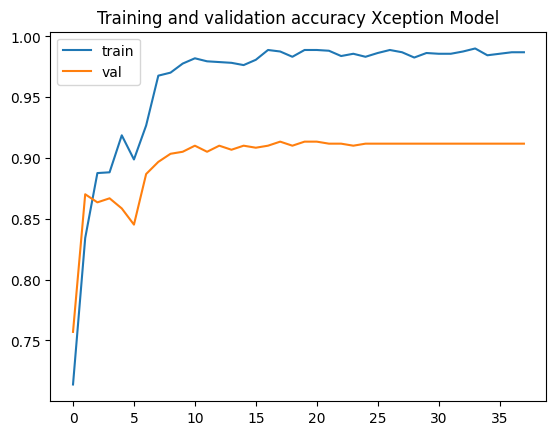

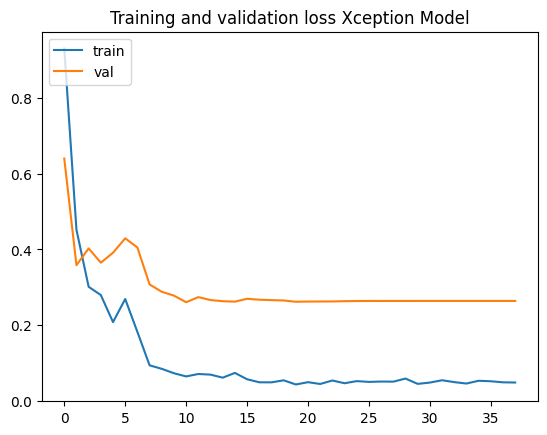

In [23]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_Xception_model_1.history['accuracy' ]
val_acc  = history_Xception_model_1.history['val_accuracy' ]
loss     = history_Xception_model_1.history['loss' ]
val_loss = history_Xception_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy Xception Model')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss Xception Model')
plt.legend(['train', 'val'], loc='upper left')

# Xception 2

In [24]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="ChilePaper_Xception_model2", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [25]:
# Define Model
Xception_model2 = tf.keras.models.Sequential([
    # Xception Layer
    Xception(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(5, activation='softmax') 
  ])
Xception_model2.layers[0].trainable = False

# Compile Model
Xception_model2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
Xception_model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 256)               524544    
                                                                 
 dense_11 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 21,387,309
Trainable params: 525,829
Non-trainable params: 20,861,480
____________________________________

In [26]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_Xception_model_2 = Xception_model2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
162/162 [==============================] - ETA: 0s - loss: 0.6336 - accuracy: 0.7436
Epoch 1: val_accuracy improved from -inf to 0.81697, saving model to ChilePaper_Xception_model2


INFO:tensorflow:Assets written to: ChilePaper_Xception_model2\assets


INFO:tensorflow:Assets written to: ChilePaper_Xception_model2\assets


162/162 [==============================] - 22s 125ms/step - loss: 0.6336 - accuracy: 0.7436 - val_loss: 0.4960 - val_accuracy: 0.8170 - lr: 0.0010
Epoch 2/100
162/162 [==============================] - ETA: 0s - loss: 0.3273 - accuracy: 0.8746
Epoch 2: val_accuracy improved from 0.81697 to 0.88186, saving model to ChilePaper_Xception_model2


INFO:tensorflow:Assets written to: ChilePaper_Xception_model2\assets


INFO:tensorflow:Assets written to: ChilePaper_Xception_model2\assets


162/162 [==============================] - 20s 121ms/step - loss: 0.3273 - accuracy: 0.8746 - val_loss: 0.3260 - val_accuracy: 0.8819 - lr: 0.0010
Epoch 3/100
162/162 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.9081
Epoch 3: val_accuracy did not improve from 0.88186
162/162 [==============================] - 7s 43ms/step - loss: 0.2529 - accuracy: 0.9081 - val_loss: 0.3713 - val_accuracy: 0.8602 - lr: 0.0010
Epoch 4/100
162/162 [==============================] - ETA: 0s - loss: 0.1746 - accuracy: 0.9379
Epoch 4: val_accuracy improved from 0.88186 to 0.90349, saving model to ChilePaper_Xception_model2


INFO:tensorflow:Assets written to: ChilePaper_Xception_model2\assets


INFO:tensorflow:Assets written to: ChilePaper_Xception_model2\assets


162/162 [==============================] - 20s 122ms/step - loss: 0.1746 - accuracy: 0.9379 - val_loss: 0.2653 - val_accuracy: 0.9035 - lr: 0.0010
Epoch 5/100
162/162 [==============================] - ETA: 0s - loss: 0.1677 - accuracy: 0.9435
Epoch 5: val_accuracy did not improve from 0.90349
162/162 [==============================] - 7s 43ms/step - loss: 0.1677 - accuracy: 0.9435 - val_loss: 0.2646 - val_accuracy: 0.8968 - lr: 0.0010
Epoch 6/100
162/162 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.9528
Epoch 6: val_accuracy did not improve from 0.90349
162/162 [==============================] - 7s 43ms/step - loss: 0.1223 - accuracy: 0.9528 - val_loss: 0.2803 - val_accuracy: 0.8935 - lr: 0.0010
Epoch 7/100
162/162 [==============================] - ETA: 0s - loss: 0.1196 - accuracy: 0.9578
Epoch 7: val_accuracy did not improve from 0.90349
162/162 [==============================] - 7s 43ms/step - loss: 0.1196 - accuracy: 0.9578 - val_loss: 0.3222 - val_accu

INFO:tensorflow:Assets written to: ChilePaper_Xception_model2\assets


INFO:tensorflow:Assets written to: ChilePaper_Xception_model2\assets


162/162 [==============================] - 19s 119ms/step - loss: 0.0991 - accuracy: 0.9634 - val_loss: 0.2771 - val_accuracy: 0.9085 - lr: 0.0010
Epoch 9/100
162/162 [==============================] - ETA: 0s - loss: 0.0905 - accuracy: 0.9708
Epoch 9: val_accuracy did not improve from 0.90849
162/162 [==============================] - 7s 43ms/step - loss: 0.0905 - accuracy: 0.9708 - val_loss: 0.3550 - val_accuracy: 0.8852 - lr: 0.0010
Epoch 10/100
162/162 [==============================] - ETA: 0s - loss: 0.0689 - accuracy: 0.9770
Epoch 10: val_accuracy did not improve from 0.90849

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
162/162 [==============================] - 7s 43ms/step - loss: 0.0689 - accuracy: 0.9770 - val_loss: 0.2954 - val_accuracy: 0.8985 - lr: 0.0010
Epoch 11/100
162/162 [==============================] - ETA: 0s - loss: 0.0320 - accuracy: 0.9919
Epoch 11: val_accuracy did not improve from 0.90849
162/162 [===========================

INFO:tensorflow:Assets written to: ChilePaper_Xception_model2\assets


INFO:tensorflow:Assets written to: ChilePaper_Xception_model2\assets


162/162 [==============================] - 20s 124ms/step - loss: 0.0292 - accuracy: 0.9926 - val_loss: 0.2532 - val_accuracy: 0.9168 - lr: 1.0000e-04
Epoch 13/100
162/162 [==============================] - ETA: 0s - loss: 0.0213 - accuracy: 0.9969
Epoch 13: val_accuracy improved from 0.91681 to 0.92013, saving model to ChilePaper_Xception_model2


INFO:tensorflow:Assets written to: ChilePaper_Xception_model2\assets


INFO:tensorflow:Assets written to: ChilePaper_Xception_model2\assets


162/162 [==============================] - 20s 120ms/step - loss: 0.0213 - accuracy: 0.9969 - val_loss: 0.2561 - val_accuracy: 0.9201 - lr: 1.0000e-04
Epoch 14/100
162/162 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9963
Epoch 14: val_accuracy did not improve from 0.92013
162/162 [==============================] - 7s 43ms/step - loss: 0.0243 - accuracy: 0.9963 - val_loss: 0.2526 - val_accuracy: 0.9151 - lr: 1.0000e-04
Epoch 15/100
162/162 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.9963
Epoch 15: val_accuracy did not improve from 0.92013
162/162 [==============================] - 7s 43ms/step - loss: 0.0206 - accuracy: 0.9963 - val_loss: 0.2559 - val_accuracy: 0.9135 - lr: 1.0000e-04
Epoch 16/100
162/162 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9963
Epoch 16: val_accuracy did not improve from 0.92013
162/162 [==============================] - 7s 43ms/step - loss: 0.0198 - accuracy: 0.9963 - val_loss:

INFO:tensorflow:Assets written to: ChilePaper_Xception_model2\assets


INFO:tensorflow:Assets written to: ChilePaper_Xception_model2\assets


162/162 [==============================] - 19s 119ms/step - loss: 0.0165 - accuracy: 0.9988 - val_loss: 0.2612 - val_accuracy: 0.9218 - lr: 1.0000e-04
Epoch 18/100
162/162 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9969
Epoch 18: val_accuracy did not improve from 0.92180
162/162 [==============================] - 7s 43ms/step - loss: 0.0189 - accuracy: 0.9969 - val_loss: 0.2635 - val_accuracy: 0.9168 - lr: 1.0000e-04
Epoch 19/100
162/162 [==============================] - ETA: 0s - loss: 0.0216 - accuracy: 0.9963
Epoch 19: val_accuracy did not improve from 0.92180

Epoch 19: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
162/162 [==============================] - 7s 43ms/step - loss: 0.0216 - accuracy: 0.9963 - val_loss: 0.2548 - val_accuracy: 0.9151 - lr: 1.0000e-04
Epoch 20/100
162/162 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 0.9963
Epoch 20: val_accuracy did not improve from 0.92180
162/162 [=============

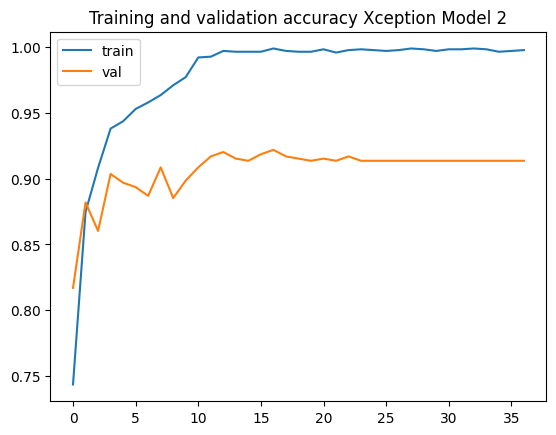

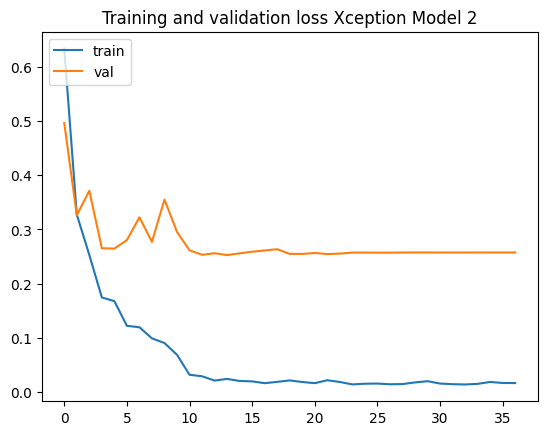

In [27]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_Xception_model_2.history['accuracy' ]
val_acc  = history_Xception_model_2.history['val_accuracy' ]
loss     = history_Xception_model_2.history['loss' ]
val_loss = history_Xception_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy Xception Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss Xception Model 2')
plt.legend(['train', 'val'], loc='upper left')